In [4]:
##### import time
import pandas as pd
from utils.hdr_utils import hdr_yuv_read
from utils.csf_utils import blockwise_csf,windows_csf
from joblib import Parallel,delayed
import numpy as np
import cv2
import queue
import glob
from colour.models import eotf_PQ_BT2100
import os
import time
import scipy.ndimage
import joblib
from scipy.stats import gmean
import sys
import skvideo
import matplotlib.pyplot as plt
import ChipQA.niqe 
import ChipQA.save_stats
from numba import jit,prange,njit
import argparse
from scipy.stats import kurtosis
from skimage.util.shape import view_as_blocks

In [18]:



C=1
def gen_gauss_window(lw, sigma):
    sd = np.float32(sigma)
    lw = int(lw)
    weights = [0.0] * (2 * lw + 1)
    weights[lw] = 1.0
    sum = 1.0
    sd *= sd
    for ii in range(1, lw + 1):
        tmp = np.exp(-0.5 * np.float32(ii * ii) / sd)
        weights[lw + ii] = tmp
        weights[lw - ii] = tmp
        sum += 2.0 * tmp
    for ii in range(2 * lw + 1):
        weights[ii] /= sum
    return weights
def compute_image_mscn_transform(image, C=1, avg_window=None, extend_mode='reflect'):
    if avg_window is None:
      avg_window = gen_gauss_window(3, 7.0/6.0)
    assert len(np.shape(image)) == 2
    h, w = np.shape(image)
    mu_image = np.zeros((h, w), dtype=np.float32)
    var_image = np.zeros((h, w), dtype=np.float32)
    image = np.array(image).astype('float32')
    scipy.ndimage.correlate1d(image, avg_window, 0, mu_image, mode=extend_mode)
    scipy.ndimage.correlate1d(mu_image, avg_window, 1, mu_image, mode=extend_mode)
    scipy.ndimage.correlate1d(image**2, avg_window, 0, var_image, mode=extend_mode)
    scipy.ndimage.correlate1d(var_image, avg_window, 1, var_image, mode=extend_mode)
    var_image = np.sqrt(np.abs(var_image - mu_image**2))
    mscn = (image - mu_image)/(var_image + C)
    return mscn, image - mu_image, var_image

def spatiotemporal_mscn(img_buffer,avg_window,extend_mode='mirror'):
    st_mean = np.zeros((img_buffer.shape))
    scipy.ndimage.correlate1d(img_buffer, avg_window, 0, st_mean, mode=extend_mode)
    return st_mean

def block_compute_lnl(block,delta,lnl_transform='exp_inv'):
    block = block.astype(np.float32)
    avg_luminance = np.average(block.flatten()+1)
    if(lnl_transform=='sigmoid'):
        block_transform =  1/(1+np.exp(-delta*(block-avg_luminance)))
    elif(lnl_transform=='nakarushton'):
        block_transform = block/(block+avg_luminance)
    elif(lnl_transform=='exp'):
        block = -4+(block-np.amin(block))* 8/(1e-3+np.amax(block)-np.amin(block))
        block_transform =  np.exp(np.abs(block)**delta)-1
        block_transform[block<0] = -block_transform[block<0]
    elif(lnl_transform=='logit'):
        block = -0.99+(block-np.amin(block))* 1.98/(1e-3+np.amax(block)-np.amin(block))
        block_transform = np.log((1+(block)**delta)/(1-(block)**delta))
        if(delta%2==0):
            block_transform[block<0] = -block_transform[block<0] 
    elif(lnl_transform=='custom'):
        block = -0.99+(block-np.amin(block))* 1.98/(1e-3+np.amax(block)-np.amin(block))
        block_transform = transform(block,delta)
   
    return block_transform

def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

@njit
def padding(img,pad):
    padded_img = np.zeros((img.shape[0]+2*pad,img.shape[1]+2*pad))
    padded_img[pad:-pad,pad:-pad] = img
    return padded_img

@njit(parallel=True)
def AdaptiveLogit(img,s,delta):
    if len(img.shape) == 3:
        raise Exception ("Single channel image only")

    H,W = img.shape
    a = s//2
    padded_img = padding(img,a)

    f_img = np.zeros(padded_img.shape)

    for i in prange(a,H+a+1):
        for j in range(a,W+a+1):
            value = logit_window(padded_img,i,j,s,delta)
            f_img[i,j] = value

    return f_img[a:-a,a:-a] 


def logit(x,delta):
    y = np.log((1+(x)**delta)/(1-(x)**delta))
#     if(delta%2==0):
#         if(len(x)==1):
#             y = -np.log((1+(x)**delta)/(1-(x)**delta))
#         y[x<0] = -np.log((1+(x[x<0])**delta)/(1-(x[x<0])**delta))
    return y
        
@njit
def logit_window(Y,x,y,s,delta):
    block = Y[x-(s//2):x+(s//2)+1,y-(s//2):y+(s//2)+1]
    center_pixel_scaled = -0.99+(block[s//2,s//2]-np.amin(block))* 1.98/(1e-3+np.amax(block)-np.amin(block))
    result = logit(center_pixel_scaled,delta)
            

            
    return result


def transform(x,delta):
    y = x.copy()
    y[x<-0.5] = logit(x[x<-0.5],delta)-logit(-0.5,delta)-0.5 
    y[x>0.5] = logit(x[x>0.5],delta)-logit(0.5,delta)+0.5 
    return y

def spatial_mscn(i,filenames,framenum,hs,ws,use_csf=True,linear=True):
    filename = filenames[i] # '/home/josh-admin/Downloads/288p_200kbps_CenterPanorama_upscaled.yuv' #
    name = os.path.basename(filename)
    print(name) 
    framenos = framenos_list[i]



    # SIZE of frames
    h,w = hs[i],ws[i]
    print(h,w)
    if(h>w):
        h_temp = h
        h=w
        w = h_temp
        
    # SIZE of windows
    h_win,w_win = 45,45
    max_h,max_w = int((h//h_win)*h_win),int((w//w_win)*w_win)
    #percent by which the image is resized
    scale_percent = 0.5
    # dsize
    dsize = (int(scale_percent*h),int(scale_percent*w))

    # opening file object
    dis_file_object = open(filename)
    Y,_,_ = hdr_yuv_read(dis_file_object,10,h,w)
#     v = skvideo.io.vread(filename, outputdict={'-ss':'0.1','-pix_fmt':'yuv444p16be','-vframes':'1'})
    
#     Y = np.squeeze(v[:,:,:,2])
#     print(Y.dtype.byteorder)
    
#     plt.imshow(Y,cmap='gray')
    print(Y.shape)
#     prevY_pq,_,_ = hdr_yuv_read(dis_file_object,framenum,h,w)
#     count=1
#     prevY_pq = prevY_pq.astype(np.float32)
    if(linear==True):
        y_pq_normalized = Y.astype(np.float32)/1023.0
        Y = eotf_PQ_BT2100(y_pq_normalized)

#     blocks = blockshaped(prevY_pq[:max_h,:max_w],h_win,w_win)
#     Y = unblockshaped(blocks,max_h,max_w)
    Y_mscn,Y_ms,_ = compute_image_mscn_transform(Y)
    lnl_mscn_list =[]
    lnl_list = []
    lnl_ms_list = []
    
    for delta in [3,5,15]:
#         block_lnl = Parallel(n_jobs=20,verbose=0)(delayed(block_compute_lnl)(block,delta,lnl_transform='logit')\
#                                                               for block in blocks) 
#         Y_lnl = unblockshaped(np.asarray(block_lnl),max_h,max_w)
        Y_lnl= block_compute_lnl(Y,delta,lnl_transform='custom')
#         start = time.time()
#         Y_lnl = AdaptiveLogit(Y,s=45,delta=delta)
#         end = time.time()
#         print(end-start)
        Y_lnl_mscn,Y_lnl_ms,_ = compute_image_mscn_transform(Y_lnl,C=1e-3)
        
        lnl_list.append(Y_lnl)
        lnl_mscn_list.append(Y_lnl_mscn)
        lnl_ms_list.append(Y_lnl_ms)
    return Y, Y_mscn,lnl_list,lnl_mscn_list,lnl_ms_list







In [ ]:
input_folder = '/media/josh/nebula_josh/hdr/fall2021_hdr_yuv'
csv_file = './fall2021_yuv_rw_info.csv'
csv_df = pd.read_csv(csv_file)
files = [os.path.join(input_folder,f) for f in csv_df["yuv"]]
fps = csv_df["fps"]
framenos_list = csv_df["framenos"]
ws =csv_df["w"]
hs = csv_df["h"]
flag = 0



%matplotlib notebook
%matplotlib notebook

delta =[1,2,3]
from scipy.stats import t

ms_means = []
mscn_means = []
std_means = []
for i,f in enumerate(files):
    if('ref' in f):
        base = os.path.splitext(os.path.basename(f))[0]
        dis_file_object = open(f)
        

        Y, Y_mscn,lnl_list,lnl_mscn_list,lnl_ms_list = spatial_mscn(i,files,10,hs,ws,linear=False)
#         plt.figure()
#         plt.clf()
#         Y = Y/65536
#         plt.imshow(Y,cmap='gray')
        print(Y.shape)
#         print(Y)

# #         Y = -Y
#         Y_mscn,Y_ms,local_std = compute_image_mscn_transform(Y)
#         plt.figure()
#         plt.clf()
#         n,bins,_ = plt.hist(Y_mscn.flatten(),bins=2500,label=r'Empirical',density=True)

    #Y_mscn,Y_ms,local_std kjkjkj.  Y,Y_mscn,Y_lnl_list,Y_lnl_mscn_list,lnl_ms_list
#         Y_mscn = - Y_mscn
        for index,Y_mscn in enumerate(lnl_mscn_list):
            Yplot = np.concatenate(Y_mscn).flatten()
            alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
            kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
            x = np.arange(-1.5,1.5,0.001)
            Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)

            student_t = t.fit(Yplot.flatten())
            print(student_t)
            student_t_fitted = t.pdf(x, loc=student_t[1], scale=student_t[2], df=student_t[0])
            plt.figure()
            plt.clf()
            n,bins,_ = plt.hist(Y_mscn.flatten(),range=[-1.5,1.5],bins=2500,label=r'Empirical',density=True)
            print(len(bins))
            print(np.mean(Yplot))
            plt.plot(x,Y_ggd,label=r'GGD fit $\alpha=$'+str(alpha)[:4])
            plt.plot(x,student_t_fitted,label=r'Student t fit $\nu=$'+str(student_t[0])[:5]+' loc= '+str(student_t[1])[:5]+' scale= '+str(student_t[2])[:5])
            ax = plt.gca()
            ax.set_ylim([0,1.4])
            plt.title('MSCN of '+base)
            plt.legend()
#         plt.imshow(Y,cmap='gray')
            if(not os.path.isdir('./images/custom_transform/')):
                os.mkdir('./images/custom_transform/')
        

            plt.savefig('./images/custom_transform/'+base+'_delta_'+str(index)+'_hist.png')


#    Parallel(n_jobs=5)(delayed(sts_fromfilename)(i,files,framenos_list,args.results_folder,use_csf=False) for i in range(len(files)))
# Y,Y_mscn,Y_lnl_list,Y_lnl_mscn_list,lnl_ms_list = spatial_mscn(187,files,10,hs,ws,linear=False)







4k_ref_Bonfire.yuv
2160 3840
(2160, 3840)
(2160, 3840)
(7.5626365569132279, -0.048498270145751469, 0.47623549401853638)


<IPython.core.display.Javascript object>

2501
0.00261314
(7.4634921352746133, -0.048291153589957517, 0.46375128746923922)


<IPython.core.display.Javascript object>

2501
0.00271549
(1.8679166031783336, -0.00017506183591692575, 0.17333940416577581)


<IPython.core.display.Javascript object>

2501
-0.00483682
4k_ref_CargoBoat.yuv
2160 3840
(2160, 3840)
(2160, 3840)
(14.068421185136881, -0.054962914608715413, 0.48806189000716366)


<IPython.core.display.Javascript object>

2501
-0.000382973
(26.029856597018014, -0.038609546962209945, 0.49721567332776406)


<IPython.core.display.Javascript object>

2501
0.000202178
(157839017719.54803, 0.19142160850844342, 0.024338470753995728)


/home/josh-admin/anaconda3/envs/general/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5984: RuntimeWarning: overflow encountered in power
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)
/home/josh-admin/anaconda3/envs/general/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5984: RuntimeWarning: overflow encountered in multiply
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)


<IPython.core.display.Javascript object>

2501
0.00353875
4k_ref_CenterPanorama.yuv
2160 3840
(2160, 3840)
(2160, 3840)
(11371.998150316946, -0.003759028018241429, 0.51656654477125019)


<IPython.core.display.Javascript object>

2501
-0.00324374
(11047.380193674971, -0.0044718046738302852, 0.51257923245486259)


<IPython.core.display.Javascript object>

2501
-0.00429454
(16.411878740008454, -0.033973760588003554, 0.45955322682940658)


<IPython.core.display.Javascript object>

2501
-0.00648355
4k_ref_Chasing1.yuv
2160 3840
(2160, 3840)
(2160, 3840)


/home/josh-admin/anaconda3/envs/general/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5990: RuntimeWarning: overflow encountered in square
  lPx -= 0.5*np.log(r*np.pi) + (r+1)/2*np.log(1+(x**2)/r)


(2.1224241617963031, -1.2102733182130958e-21, 1.4723024247847846e-19)


<IPython.core.display.Javascript object>

2501
0.000811454


/home/josh-admin/anaconda3/envs/general/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5990: RuntimeWarning: overflow encountered in square
  lPx -= 0.5*np.log(r*np.pi) + (r+1)/2*np.log(1+(x**2)/r)


(1.9876613047292695, -1.703394676158333e-20, 1.4602075214517816e-19)


<IPython.core.display.Javascript object>

2501
0.000209992


/home/josh-admin/anaconda3/envs/general/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5990: RuntimeWarning: overflow encountered in square
  lPx -= 0.5*np.log(r*np.pi) + (r+1)/2*np.log(1+(x**2)/r)


(1.9878951377252299, -4.7073125999229943e-20, 1.4435297949827179e-19)


<IPython.core.display.Javascript object>

2501
-0.0015707
4k_ref_Chasing3.yuv
2160 3840
(2160, 3840)
(2160, 3840)
(647.82195137091276, 0.014258884162501546, 0.56490108370840164)


<IPython.core.display.Javascript object>

2501
0.0143898
(153.93649299350716, 0.018674254283143905, 0.54802414774922825)


<IPython.core.display.Javascript object>

2501
0.0179264
(3.0476252722122945, -0.0039541380186041888, 0.29034645855468771)


<IPython.core.display.Javascript object>

2501
0.0194171
4k_ref_Chasing4.yuv
2160 3840
(2160, 3840)
(2160, 3840)
(8.2709634638247636, -0.020367580039043875, 0.45240180194440027)


<IPython.core.display.Javascript object>

2501
0.00957224
(8.4180930577973569, -0.018504857422610363, 0.44928909838227038)


<IPython.core.display.Javascript object>

2501
0.00640058
(6.4426267137155921, -0.011414563234230578, 0.38188196718738909)


<IPython.core.display.Javascript object>

2501
-0.00877869
4k_ref_CourtYard.yuv
2160 3840
(2160, 3840)
(2160, 3840)
(18.191268524663649, 0.015528759446239222, 0.47630108892933576)


<IPython.core.display.Javascript object>

2501
0.00839498
(7.8774473947914849, -0.045544054997899014, 0.45669291913607313)


<IPython.core.display.Javascript object>

2501
0.00824652
(1320.2956495528801, 0.0089803342735104187, 0.50654163146578224)


/tmp/ipykernel_709008/1584864245.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>

2501
0.00885211
4k_ref_Daylight1.yuv
2160 3840
(2160, 3840)
(2160, 3840)
(5.0825552544960217, -0.010339365134310073, 0.29989697039157204)


<IPython.core.display.Javascript object>

2501
0.000556082
(4.9964465996883742, -0.0097205098830442736, 0.29499225337948332)


<IPython.core.display.Javascript object>

2501
0.00107523
(1.8239517184157075, 0.00030219042010958864, 0.17068930715339869)


<IPython.core.display.Javascript object>

2501
0.00214093
4k_ref_firework.yuv
2160 3840
(2160, 3840)
(2160, 3840)
(88166288689.902344, -0.19064340835463356, 0.033046393208408256)


/home/josh-admin/anaconda3/envs/general/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5984: RuntimeWarning: overflow encountered in power
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)
/home/josh-admin/anaconda3/envs/general/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:5984: RuntimeWarning: overflow encountered in multiply
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)


<IPython.core.display.Javascript object>

2501
0.00896168


In [ ]:
input_folder = '/media/josh/nebula_josh/hdr/fall2021_hdr_yuv'
csv_file = './fall2021_yuv_rw_info.csv'
csv_df = pd.read_csv(csv_file)
files = [os.path.join(input_folder,f) for f in csv_df["yuv"]]
fps = csv_df["fps"]
framenos_list = csv_df["framenos"]
ws =csv_df["w"]
hs = csv_df["h"]
flag = 0


%matplotlib notebook
%matplotlib notebook

delta =[1,2,3]
from scipy.stats import t

ms_means = []
mscn_means = []
std_means = []

f = "/media/josh/nebula_josh/hdr/data_gen_code/test_old_420p10le_firework.yuv"
base = os.path.splitext(os.path.basename(f))[0]
dis_file_object = open(f)

plt.figure()
plt.clf()
Y2,_,_ = hdr_yuv_read(dis_file_object,10,2160,3840)
print(Y2.dtype.byteorder)

Y2_mscn,Y_ms,local_std = compute_image_mscn_transform(Y2,C=1)
print(np.mean(Y2_mscn))
print(np.median(Y2_mscn))

n,bins,_ = plt.hist(Y2_mscn.flatten(),range=[-1.5,1.5],bins=2500,label=r'Empirical',density=True)

plt.figure()
plt.clf()
#         Y2 = Y2/1024
print(Y2)
plt.imshow(Y2,cmap='gray')
#       
        

f = "/media/josh/nebula_josh/hdr/data_gen_code/test_yuv444p10le_firework.yuv"
base = os.path.splitext(os.path.basename(f))[0]
dis_file_object = open(f)

plt.figure()
plt.clf()
Y3,_,_ = hdr_yuv_read(dis_file_object,10,2160,3840)
Y2_mscn,Y_ms,local_std = compute_image_mscn_transform(Y3/65535.0,C=1e-3)
n,bins,_ = plt.hist(Y2_mscn.flatten(),range=[-1.5,1.5],bins=2500,label=r'Empirical',density=True)

print(Y3.dtype.byteorder)
print(np.amax(Y3))
# Y2_mscn,Y_ms,local_std = compute_image_mscn_transform(Y2)
plt.figure()
plt.clf()
#         Y2 = Y2/1024
print(Y3)
plt.imshow(Y3,cmap='gray')
        #         n,bins,_ = plt.hist(Y2.flatten(),bins=2500,label=r'Empirical',density=True)


<IPython.core.display.Javascript object>


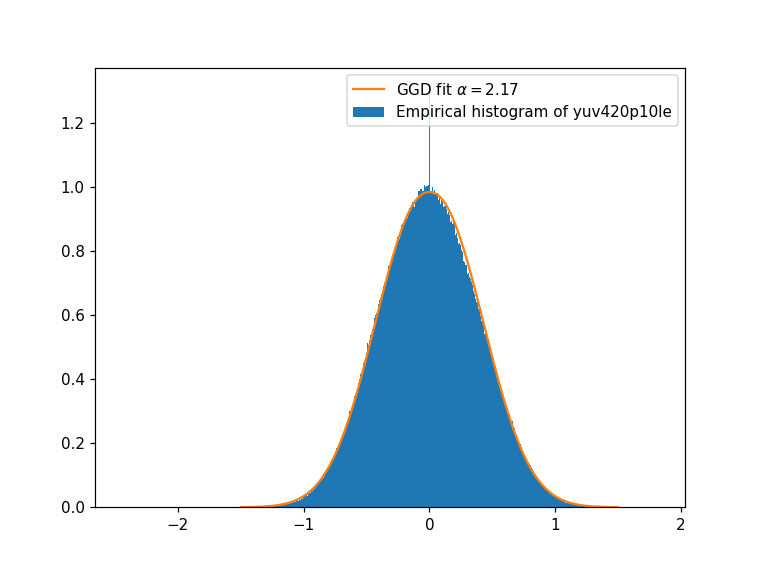

=
738
412.827402103
411.0


<IPython.core.display.Javascript object>


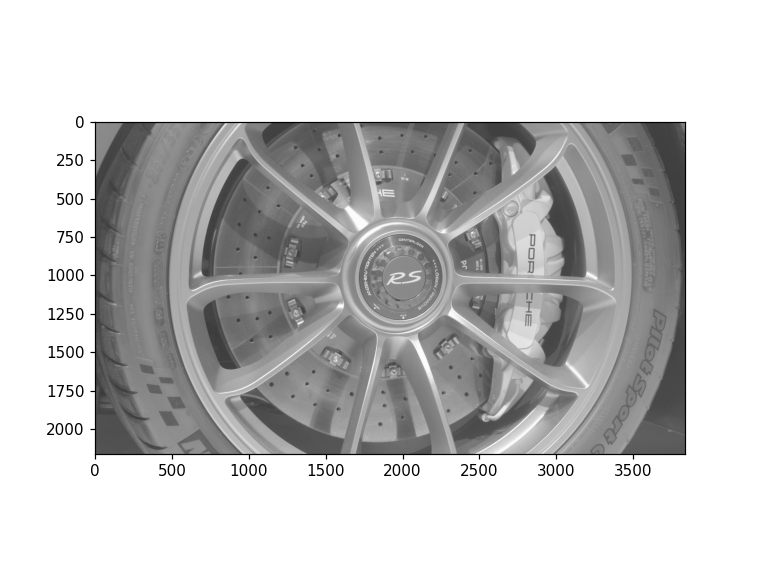

[[ 0.44281524  0.43206257  0.42424244 ...,  0.5591398   0.5601173
   0.5669599 ]
 [ 0.43890518  0.4349951   0.43010753 ...,  0.5610948   0.5650049
   0.5669599 ]
 [ 0.4349951   0.4340176   0.43304008 ...,  0.5591398   0.5650049
   0.56891495]
 ..., 
 [ 0.27761486  0.2805474   0.2805474  ...,  0.29325512  0.29423264
   0.29521015]
 [ 0.27761486  0.2805474   0.28347996 ...,  0.29423264  0.29325512
   0.29423264]
 [ 0.27761486  0.28250244  0.285435   ...,  0.29521015  0.29521015
   0.2922776 ]]


<IPython.core.display.Javascript object>


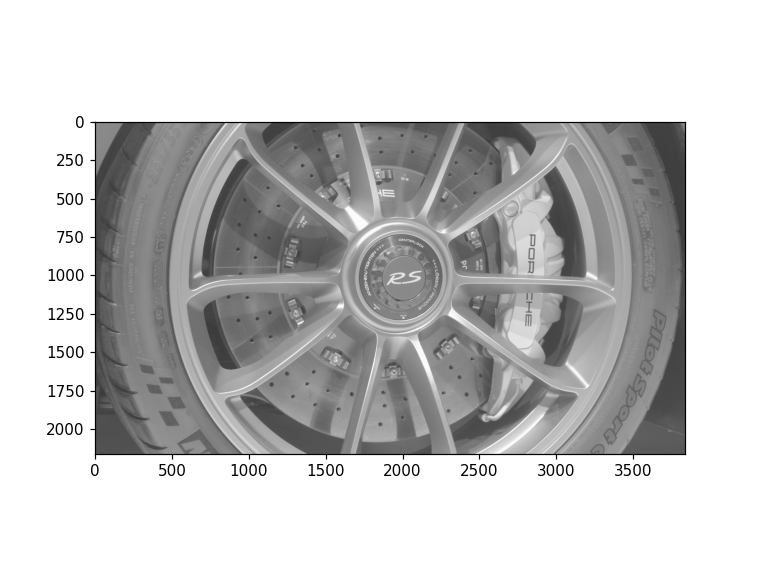

<IPython.core.display.Javascript object>


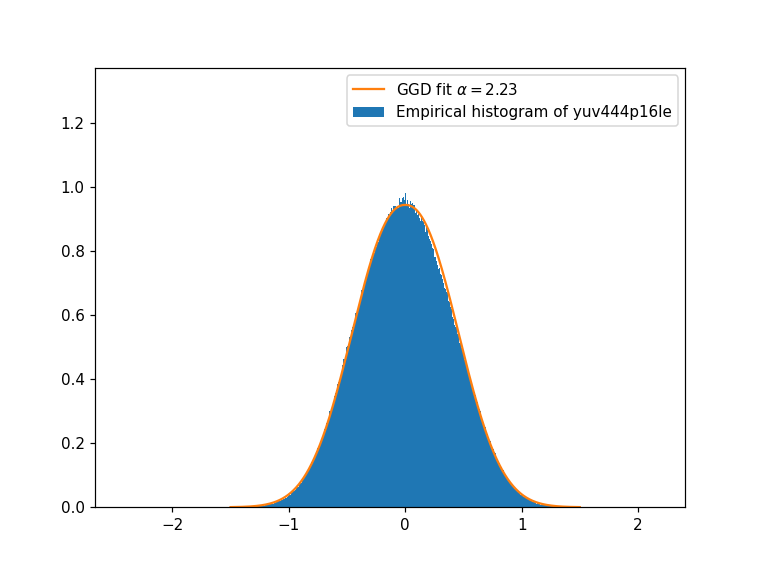

=
47232
26415.5257407
26304.0
[[ 0.441413    0.4316472   0.42285803 ...,  0.56348515  0.56446177
   0.5664149 ]
 [ 0.43848327  0.43457696  0.4287175  ...,  0.55957884  0.56348515
   0.56543833]
 [ 0.4365301   0.4365301   0.43360037 ...,  0.55469596  0.561532
   0.56348515]
 ..., 
 [ 0.27832457  0.27930114  0.27930114 ...,  0.29102007  0.29492638
   0.29590297]
 [ 0.27930114  0.27930114  0.28027773 ...,  0.29297322  0.2939498
   0.2939498 ]
 [ 0.2812543   0.28223088  0.27930114 ...,  0.2939498   0.29297322
   0.29102007]]
[[ 63.85871965  64.          63.85253456 ...,  64.55944056  64.55846422
   64.        ]
 [ 64.          64.          63.85454545 ...,  63.88850174  63.88927336
   63.88965517]
 [ 64.28764045  64.43243243  64.14446953 ...,  63.55244755  63.66782007
   63.45017182]
 ..., 
 [ 64.22535211  63.77700348  63.77700348 ...,  63.57333333  64.21262458
   64.21192053]
 [ 64.45070423  63.77700348  63.33793103 ...,  63.78737542  64.21333333
   64.        ]
 [ 64.90140845  64.       

In [47]:
input_folder = '/media/josh/nebula_josh/hdr/fall2021_hdr_yuv'
csv_file = './fall2021_yuv_rw_info.csv'
csv_df = pd.read_csv(csv_file)
files = [os.path.join(input_folder,f) for f in csv_df["yuv"]]
fps = csv_df["fps"]
framenos_list = csv_df["framenos"]
ws =csv_df["w"]
hs = csv_df["h"]
flag = 0


%matplotlib notebook
%matplotlib notebook

delta =[1,2,3]
from scipy.stats import t

ms_means = []
mscn_means = []
std_means = []

f = "/media/josh/nebula_josh/hdr/data_gen_code/test_yuv420p10le_porsche.yuv"
base = os.path.splitext(os.path.basename(f))[0]
dis_file_object = open(f)

plt.figure()
plt.clf()
Y2,_,_ = hdr_yuv_read(dis_file_object,10,2160,3840)
print(Y2.dtype.byteorder)
normalized_Y2 = Y2.astype('float32')/1023.0

Y2_mscn,Y_ms,local_std = compute_image_mscn_transform(normalized_Y2,C=1e-3)
print(np.amax(Y2))

print(np.mean(Y2))
print(np.median(Y2))

n,bins,_ = plt.hist(Y2_mscn.flatten(),bins=2500,label=r'Empirical histogram of yuv420p10le',density=True)

Yplot = Y2_mscn.flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-1.5,1.5,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
plt.plot(x,Y_ggd,label=r'GGD fit $\alpha=$'+str(alpha)[:4])
plt.legend()
     
plt.figure()
plt.clf()
#         Y2 = Y2/1024
print(Y2.astype('float32')/1023.0)
plt.imshow(Y2,cmap='gray')
#       
        

f = "/media/josh/nebula_josh/hdr/data_gen_code/test_yuv444p16le_porsche.yuv"
base = os.path.splitext(os.path.basename(f))[0]
dis_file_object = open(f)

plt.figure()
plt.clf()
Y3,_,_ = hdr_yuv_read(dis_file_object,10,2160,3840)
plt.imshow(Y3,cmap='gray')

plt.figure()
plt.clf()
normalized_Y3 = Y3.astype('float32')/(2**16-1)
Y3_mscn,Y_ms,local_std = compute_image_mscn_transform(normalized_Y3,C=1e-3)
n,bins,_ = plt.hist(Y3_mscn.flatten(),bins=2500,label=r'Empirical histogram of yuv444p16le',density=True)

Yplot = Y3_mscn.flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-1.5,1.5,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
plt.plot(x,Y_ggd,label=r'GGD fit $\alpha=$'+str(alpha)[:4])
   
    

plt.legend()


print(Y3.dtype.byteorder)
print(np.amax(Y3))
print(np.mean(Y3))
print(np.median(Y3))
# Y2_mscn,Y_ms,local_std = compute_image_mscn_transform(Y2)
# plt.figure()
# plt.clf()
#         Y2 = Y2/1024
print(Y3.astype('float32')/65535.0)
# plt.imshow(Y3,cmap='gray')
Y4 = Y3/Y2
print(Y4)
# plt.figure()
# plt.clf()
# n,bins,_ = plt.hist(Y4.flatten(),bins=2500,density=True)

        #         n,bins,_ = plt.hist(Y2.flatten(),bins=2500,label=r'Empirical',density=True)


[[ 0.00140226  0.00041535  0.00138441 ..., -0.00434536 -0.00434446
   0.00054502]
 [ 0.00042191  0.00041816  0.00139004 ...,  0.00151598  0.00151974
   0.00152159]
 [-0.001535   -0.00251251 -0.00056028 ...,  0.00444382  0.00347286
   0.0054298 ]
 ..., 
 [-0.00070971  0.00124627  0.00124627 ...,  0.00223505 -0.00069374
  -0.00069281]
 [-0.00168628  0.00124627  0.00320223 ...,  0.00125942 -0.00069469
   0.00028282]
 [-0.00363943  0.00027156  0.00613385 ...,  0.00126034  0.00223693
   0.00125754]]


<IPython.core.display.Javascript object>


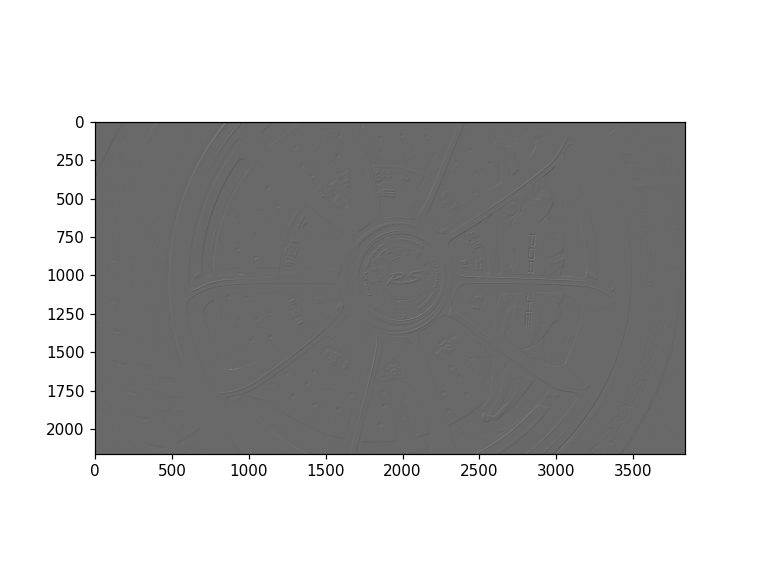

<IPython.core.display.Javascript object>


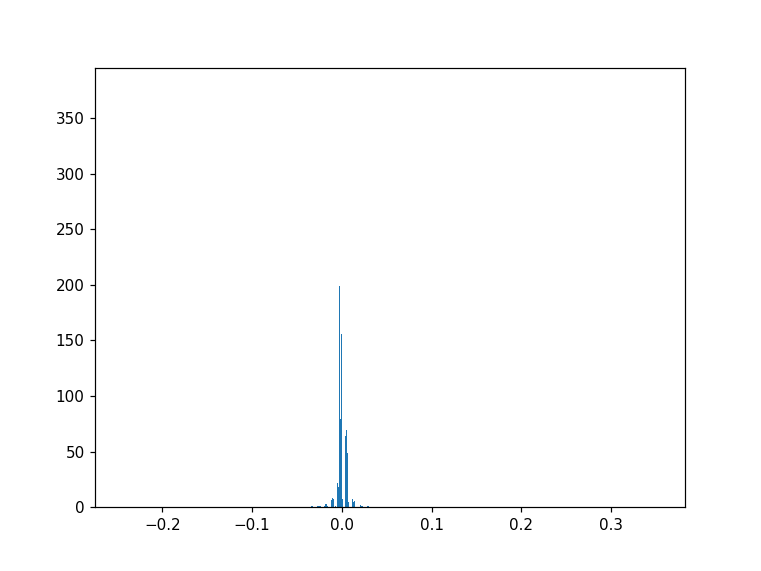

In [45]:
print(Y2.astype('float32')/1023.0-Y3.astype('float32')/65535.0)
Y4 = Y2.astype('float32')/1023.0-Y3.astype('float32')/65535.0
plt.figure()
plt.imshow(Y4,cmap='gray')
plt.figure()

n,bins,_ = plt.hist(Y4.flatten(),bins=2500,label=r'Empirical histogram of difference image',density=True)


In [46]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

PSNR(normalized_Y2,normalized_Y3)

41.838530479636439

In [20]:
i = 12
j = 23
print(Y2[i, j], Y3[i, j])
q, r = np.divmod(Y3, 2**6)
print(r.max())
Y4 = (Y2.astype('uint16') << 6)
print(Y2.astype('uint16')[i, j], bin(Y2.astype('uint16')[i, j]))
print(Y3.astype('uint16')[i, j], bin(Y3.astype('uint16')[i, j]))
print(Y3.astype('uint16')[i, j] >> 6, bin(Y3.astype('uint16')[i, j] >> 6))
print(Y4[i, j], bin(Y4[i, j]))
print((Y4[i , j] | (Y4[i, j] >> 10)), bin(Y4[i , j] | (Y4[i, j] >> 10)))

160 10240
0
160 0b10100000
10240 0b10100000000000
160 0b10100000
10240 0b10100000000000
10250 0b10100000001010


# Reference MSCNs

In [32]:


%matplotlib notebook
%matplotlib notebook

delta =[1,2,3]
from scipy.stats import t
# for index,Y_lnl_mscn in enumerate(Y_lnl_mscn_list):
#     if(index==0):
#         continue
#     print(np.amax(Y_lnl_mscn))
#     Yplot = np.concatenate(Y_lnl_mscn).flatten()
#     sigma = np.var(Yplot.flatten())
#     nu = 2*sigma/(sigma-1)
#     print(nu)
#     student_t = t.fit(Yplot.flatten(),floc=0)
#     print(student_t)
#     alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot)
#     kurt = kurtosis(Yplot,fisher=False)
#     x = np.arange(-2,2,0.001)
#     student_t_fitted = t.pdf(x, loc=student_t[1], scale=student_t[2], df=student_t[0])

#     Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
#     Y_lnl = Y_lnl_list[index]
    

# # plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
# #plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# # plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


#     plt.figure()
#     plt.clf()
#     plt.hist(Yplot,bins='auto',histtype='step',label=r'Empirical',density=True)

# #     plt.hist(Yplot,bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
#     plt.plot(x,Y_ggd, label=r'GGD fit $\alpha=$'+str(alpha)[:4])
#     plt.plot(x,student_t_fitted,label=r'Student t fit $\nu=$'+str(nu)[:5])
#     plt.ylabel('Empirical distribution')
#     plt.xlabel('MSCN')
#     plt.title('Histogram of nonlinear MSCN')
#     plt.legend()
#     plt.show()
    

Yplot = np.concatenate(Y_mscn).flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-2,2,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
student_t = t.fit(Yplot.flatten(),floc=0)
student_t_fitted = t.pdf(x, loc=student_t[1], scale=student_t[2], df=student_t[0])
plt.figure()
plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'Empirical',density=True)
plt.plot(x,Y_ggd,label=r'GGD fit $\alpha=$'+str(alpha)[:4])
plt.plot(x,student_t_fitted,label=r'Student t fit $\nu=$'+str(nu)[:5])

plt.ylabel('Empirical distribution')
plt.xlabel('MSCN')
plt.title('Histogram of original image MSCNs')
plt.legend()
plt.show()
    
# plt.figure()
# plt.clf()
# Yplot = Y.flatten()
# plt.hist(Yplot,bins='auto',histtype='step',label=r'original image',density=True)
# plt.legend()

NameError: name 'Y_mscn' is not defined

In [ ]:


%matplotlib notebook
%matplotlib notebook

delta =[1,1.5,2]

for index,Y_lnl_ms in enumerate(lnl_ms_list):
    Yplot = np.concatenate(Y_lnl_ms).flatten()
    alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
    kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
    x = np.arange(-1,1,0.0001)
    Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
    

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


    plt.figure()
    plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
    plt.plot(x,Y_ggd)
    plt.ylabel('Empirical distribution')
    plt.xlabel('MSCN')
    plt.title('Histogram of nonlinear MS')
    plt.legend()
    plt.show()
    


In [ ]:
max_h,max_w = Y_lnl.shape[0],Y_lnl.shape[1]
h_win,w_win = 45,45
for index,Y_lnl_mscn in enumerate(Y_lnl_mscn_list):
    Y_lnl = Y_lnl_list[index]

    blocks = blockshaped(Y_lnl[:max_h,:max_w],h_win,w_win)
    
    block_mscn,_ = compute_image_mscn_transform(blocks[87],C=1e-3)

    Yplot = np.concatenate(block_mscn).flatten()
    alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
    kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
    x = np.arange(-2,2,0.001)
    Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
    

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


    plt.figure()
    plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
    plt.plot(x,Y_ggd)
    plt.ylabel('Empirical distribution')
    plt.xlabel('MSCN')
    plt.title('Histogram of nonlinear MSCN of one block')
    plt.legend()
    plt.show()
    
plt.figure()
plt.imshow(blocks[45],cmap='gray')

# Reference second order stats

In [ ]:


%matplotlib notebook
%matplotlib notebook

delta =[1,3,5]

def get_aggd(aggd_feats):
    alpha = aggd_feats[0]
    sigma_l  = np.sqrt(aggd_feats[1])
    sigma_r  = np.sqrt(aggd_feats[2])
    x1 = np.arange(-2,0,0.001)
    x2 = np.arange(0,2,0.001)
    Y_aggd = ChipQA.save_stats.generate_aggd(x1,x2,alpha,sigma_l,sigma_r)
    return Y_aggd

for index,Y_lnl_mscn in enumerate(Y_lnl_mscn_list):
    pps1, pps2, pps3, pps4 = ChipQA.save_stats.paired_product(Y_lnl_mscn)
    aggd_features = ChipQA.save_stats.all_aggd(Y_lnl_mscn)
    print(aggd_features.shape)
    first_order = aggd_features[0:4]
    H_feats = aggd_features[4:8]
    V_feats = aggd_features[8:12]
    D1_feats = aggd_features[12:16]
    D2_feats = aggd_features[16:20]

    H_aggd = get_aggd(H_feats)
    V_aggd = get_aggd(V_feats)
    D1_aggd = get_aggd(D1_feats)
    D2_aggd = get_aggd(D2_feats)

    Y_lnl = Y_lnl_list[index]
    x = np.arange(-2,2,0.001)
    
    Yplot = pps1.flatten()
    kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


    plt.figure()
    plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(H_feats[0])[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
    plt.plot(x,H_aggd)
    plt.ylabel('Empirical distribution')
    plt.xlabel('MSCN')
    plt.title('Histogram of nonlinear Horizontal MSCN')
    plt.legend()
    plt.show()
    

Yplot = np.concatenate(Y_mscn).flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-2,2,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)

plt.figure()
plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4],density=True)
plt.plot(x,Y_ggd)
plt.ylabel('Empirical distribution')
plt.xlabel('MSCN')
plt.title('Histogram of original image MSCNs')
plt.legend()
plt.show()
    
plt.figure()
plt.clf()
Yplot = Y.flatten()
plt.hist(Yplot,bins='auto',histtype='step',label=r'original image',density=True)
plt.legend()

## Reference LNL images

In [ ]:
%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.clf()
Y_fcfs = -0.99+(Y-np.amin(Y))* 1.98/(np.amax(Y)-np.amin(Y))

h_top = Y_fcfs.shape[0]//2
w_top = Y_fcfs.shape[1]//2
plt.imshow(Y_fcfs,cmap='gray')
print(Y.shape)
for index,Y_lnl in enumerate(Y_lnl_list):
    Y_lnl = Y_lnl.astype(np.float32)
    plt.figure()

    plt.clf()
    Y_fcfs = (Y_lnl-np.amin(Y_lnl))/(np.amax(Y_lnl)-np.amin(Y_lnl))
    h_top = Y_fcfs.shape[0]//2
    w_top = Y_fcfs.shape[1]//2
    print(np.amin(Y_lnl))
    print(Y_fcfs.shape)
    plt.imshow(Y_fcfs,cmap='gray')

    plt.savefig('./images/nonoverlap_check_'+str(index)+'.png')
    print(Y_lnl.shape)

## Reference MSCN

In [ ]:
%matplotlib notebook
%matplotlib notebook

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)

%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.clf()
Y_fcfs = (Y_mscn-np.amin(Y_mscn))/(np.amax(Y_mscn)-np.amin(Y_mscn))
plt.imshow(Y_mscn,cmap='gray')
print(Y_fcfs.shape)
for Y_lnl_mscn in Y_lnl_mscn_list:
    plt.figure()

    plt.clf()
    Y_fcfs = (Y_lnl_mscn-np.amin(Y_lnl_mscn))/(np.amax(Y_lnl_mscn)-np.amin(Y_lnl_mscn))
    
    h_top = Y_fcfs.shape[0]//2
    w_top = Y_fcfs.shape[1]//2

    plt.imshow(Y_fcfs,cmap='gray')
plt.figure()
blur = cv2.GaussianBlur(Y_fcfs[h_top:h_top+500,w_top:w_top+500],(5,5),0)
plt.imshow(Y_fcfs[h_top:h_top+500,w_top:w_top+500],cmap='gray')

In [ ]:
%matplotlib notebook
%matplotlib notebook



for Y_lnl in Y_lnl_list:
    Y_lnl = Y_lnl.astype(np.float32)

    plt.figure()
    plt.clf()
    Yplot = Y_lnl.flatten()
    plt.hist(Yplot,bins='auto',histtype='step',density=True)
    plt.show()

    print(Y_lnl.shape)


## Distorted MSCN

In [ ]:


%matplotlib notebook
%matplotlib notebook

delta =[1,3,5]

for index,Y_lnl_mscn in enumerate(Y_lnl_mscn_list):
    Yplot = np.concatenate(Y_lnl_mscn).flatten()
    alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
    kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
    x = np.arange(-2,2,0.001)
    Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
    Y_lnl = Y_lnl_list[index]
    

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


    plt.figure()
    plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
    plt.plot(x,Y_ggd)
    plt.ylabel('Empirical distribution')
    plt.xlabel('MSCN')
    plt.title('Histogram of nonlinear MSCN')
    plt.legend()
    plt.show()
    

Yplot = np.concatenate(Y_mscn).flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-2,2,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)

plt.figure()
plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4],density=True)
plt.plot(x,Y_ggd)
plt.ylabel('Empirical distribution')
plt.xlabel('MSCN')
plt.title('Histogram of distorted image MSCNs')
plt.legend()
plt.show()
    
plt.figure()
plt.clf()
Yplot = Y.flatten()
plt.hist(Yplot,bins='auto',histtype='step',label=r'Distorted image',density=True)
plt.legend()




## Distorted LNL images

In [ ]:
%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.clf()
plt.imshow(Y[h_top:h_top+166,w_top:w_top+166],cmap='gray')
# plt.imshow(Y,cmap='gray')
for Y_lnl in Y_lnl_list:
    plt.figure()

    plt.clf()
    Y_fcfs = (Y_lnl-np.amin(Y_lnl))/(np.amax(Y_lnl)-np.amin(Y_lnl))
    
    h_top = Y_fcfs.shape[0]//2
    w_top = Y_fcfs.shape[1]//2

    plt.imshow(Y_fcfs[h_top:h_top+166,w_top:w_top+166],cmap='gray')

In [ ]:
%matplotlib notebook
%matplotlib notebook



for Y_lnl in Y_lnl_list:
    Y_lnl = Y_lnl.astype(np.float32)

    plt.figure()
    plt.clf()
    Yplot = Y_lnl.flatten()
    plt.hist(Yplot,bins='auto',histtype='step',density=True)
    plt.show()

    print(Y_lnl.shape)

## Distorted MSCN images

In [ ]:
%matplotlib notebook
%matplotlib notebook

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)

%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.clf()
Y_fcfs = (Y_mscn-np.amin(Y_mscn))/(np.amax(Y_mscn)-np.amin(Y_mscn))
plt.imshow(Y_mscn[h_top:h_top+166,w_top:w_top+166],cmap='gray')
for Y_lnl_mscn in Y_lnl_mscn_list:
    plt.figure()

    plt.clf()
    Y_fcfs = (Y_lnl_mscn-np.amin(Y_lnl_mscn))/(np.amax(Y_lnl_mscn)-np.amin(Y_lnl_mscn))
    
    h_top = Y_fcfs.shape[0]//2
    w_top = Y_fcfs.shape[1]//2

    plt.imshow(Y_fcfs[h_top:h_top+166,w_top:w_top+166],cmap='gray')

In [ ]:
from matplotlib.colors import Normalize
plt.figure()
plt.clf()
Y_mscn_fcfs = (Y_mscn-np.min(Y_mscn))/(np.amax(Y_mscn)-np.amin(Y_mscn))
plt.imshow(Y_mscn_fcfs[1400:2000,1000:1300],norm=Normalize(),cmap='gray')

In [ ]:
plt.figure()
plt.clf()
Y_lnl_mscn = Y_lnl_mscn_list[2]

plt.clf()
Y_fcfs = (Y_lnl_mscn-np.min(Y_lnl_mscn))/(np.amax(Y_lnl_mscn)-np.amin(Y_lnl_mscn))

plt.imshow(Y_fcfs[1400:2000,1000:1300],norm=Normalize(),cmap='gray')

In [ ]:
x = np.arange(0,1024)
y = x/(x+512)
plt.figure()
plt.clf()
plt.xlabel('L')
plt.ylabel('R')
plt.plot(x,y)

In [ ]:
for delta in [0.001,0.005,0.01]:
    x = np.arange(0,1024)
    y = 1/(1+np.exp(-delta*(x-512)))
    plt.figure()
    plt.clf()
    plt.ylabel('Sigmoid f(x,$\delta$='+str(delta)+')')
    plt.xlabel('x')
    plt.plot(x,y)

In [ ]:
plt.figure()
plt.clf()
for delta in [1,1.5,2]:
    x = np.arange(-4,4,0.01)

    y2 = np.exp(np.abs(x)**delta)-1
    y2[x<0] = -y2[x<0]
#     print(y)


    plt.plot(x,y2,label=' $\delta$='+str(delta))
plt.legend()
plt.ylabel('y=f(x)')
plt.xlabel('x')
plt.title('Parametrized piecewise odd exp function')
plt.show()


In [ ]:
plt.figure()
plt.clf()
for delta in [1,2,3]:
    x = np.arange(-1,1,0.01)
    x_d = (x)**delta
    y = np.log((1+x_d)/(1-x_d))
    if(delta==2):
        y[x<0] = -y[x<0]
#     y2 = np.exp(x**delta)-1
#     y2[x<0] = -y2[x<0]
#     print(y)


    plt.plot(x,y,label='logit $\delta$='+str(delta))
#     plt.plot(x,y2,label='exp $\delta$='+str(delta))
plt.legend()
plt.ylabel('y=$\log \\frac{((1+x^{\delta})}{(1-x^{\delta}))}$')
plt.xlabel('x')
plt.title('Parametrized logit function')

In [ ]:
plt.figure()
plt.clf()
for delta in [1,3,5]:
    x = np.arange(-1,1,0.01)
    x_d = (x)**delta
    y = -2*delta*(x**(delta-1))/(x**(2*delta)-1)
#     print(y)


    plt.plot(x,y,label='$\delta$='+str(delta))
plt.legend()
plt.ylabel('y=$-2\delta \\frac{(x^{(\delta-1)})}{(x^{2\delta}-1)}$')
plt.xlabel('x')
plt.title('Derivative of parametrized logit function')

In [ ]:
plt.figure()
block = np.arange(-1,1,0.01)
delta = 1
block = -2+(block-np.amin(block))* 4/(1e-3+np.amax(block)-np.amin(block))
block_transform =  np.exp(np.abs(block)**delta)-1
block_transform[block<0] = -block_transform[block<0]
plt.plot(block_transform)
plt.show()

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

img1 = cv2.imread('/home/josh-admin/Documents/hdr_plots/local_nonlinear_plots_v3/vid188_local_logit_delta1.png')
img2 = cv2.imread('/home/josh-admin/Documents/hdr_plots/sliding_window_lnl/vid188_logit_delta1.png')
im_v = cv2.hconcat([img1, img2])
plt.figure()
plt.imshow(im_v)
plt.title('Non-overlapping patches on left, Overlapping patches on right')

img1 = cv2.imread('/home/josh-admin/Documents/hdr_plots/local_nonlinear_plots_v3/vid188_local_logit_delta3.png')
img2 = cv2.imread('/home/josh-admin/Documents/hdr_plots/sliding_window_lnl/vid188_logit_delta3.png')
im_v = cv2.hconcat([img1, img2])
plt.figure()
plt.imshow(im_v)
plt.title('Non-overlapping patches on left, Overlapping patches on right')


img1 = cv2.imread('/home/josh-admin/Documents/hdr_plots/local_nonlinear_plots_v3/vid188_local_logit_delta3_mscn_hist.png')
img2 = cv2.imread('/home/josh-admin/Documents/hdr_plots/sliding_window_lnl/vid188_logit_delta3_mscn_hist.png')
im_v = cv2.hconcat([img1, img2])
plt.figure()
plt.imshow(im_v)
plt.title('Non-overlapping patches on left, Overlapping patches on right')


[-0.99       -0.98005525 -0.9701105  -0.96016575 -0.95022099 -0.94027624
 -0.93033149 -0.92038674 -0.91044199 -0.90049724 -0.89055249 -0.88060773
 -0.87066298 -0.86071823 -0.85077348 -0.84082873 -0.83088398 -0.82093923
 -0.81099448 -0.80104972 -0.79110497 -0.78116022 -0.77121547 -0.76127072
 -0.75132597 -0.74138122 -0.73143646 -0.72149171 -0.71154696 -0.70160221
 -0.69165746 -0.68171271 -0.67176796 -0.6618232  -0.65187845 -0.6419337
 -0.63198895 -0.6220442  -0.61209945 -0.6021547  -0.59220994 -0.58226519
 -0.57232044 -0.56237569 -0.55243094 -0.54248619 -0.53254144 -0.52259669
 -0.51265193 -0.50270718 -0.49276243 -0.48281768 -0.47287293 -0.46292818
 -0.45298343 -0.44303867 -0.43309392 -0.42314917 -0.41320442 -0.40325967
 -0.39331492 -0.38337017 -0.37342541 -0.36348066 -0.35353591 -0.34359116
 -0.33364641 -0.32370166 -0.31375691 -0.30381215 -0.2938674  -0.28392265
 -0.2739779  -0.26403315 -0.2540884  -0.24414365 -0.2341989  -0.22425414
 -0.21430939 -0.20436464 -0.19441989 -0.18447514 -0.

<IPython.core.display.Javascript object>


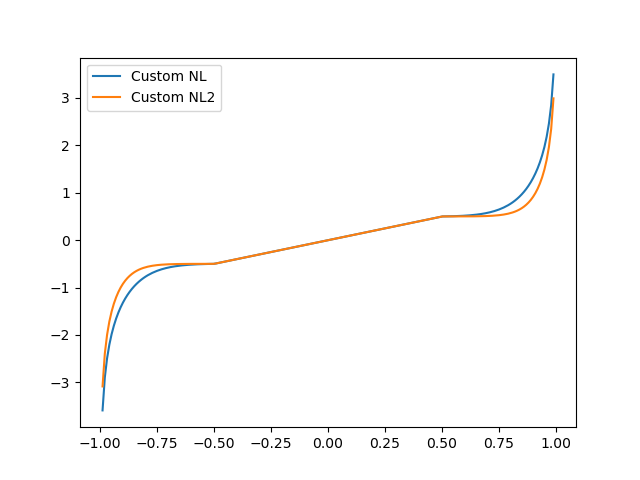

In [17]:
delta = 5

def logit(x,delta):
    return np.log((1+x**delta)/(1-x**delta))

def transform(x,delta):
    y = x.copy()
    y[x<-0.5] = logit(x[x<-0.5],delta)-logit(-0.5,delta)-0.5 
    y[x>0.5] = logit(x[x>0.5],delta)-logit(0.5,delta)+0.5 
    return y


block = np.arange(-1,1,0.01) 


block_scaled = -0.99+(block-np.amin(block))* 1.98/(1e-3+np.amax(block)-np.amin(block))
print(block_scaled)
block_transform =  transform(block_scaled,9)
block_transform2 =  transform(block_scaled,15)

block_logit = logit(block_scaled,delta)
# block_transform[block<0] = -block_transform[block<0]
plt.figure()

plt.plot(block_scaled,block_transform,label='Custom NL')
plt.plot(block_scaled,block_transform2,label='Custom NL2')

# plt.plot(block_scaled,block_logit,label='logit')

# plt.plot(block_scaled,block_scaled,label='L')
plt.legend()

plt.show()